# User-side adaptation

In [ ]:
# !pip install --quiet continuum

In [1]:
import numpy as np
import os
import os.path as osp
import random
from collections import OrderedDict
from collections import defaultdict as dd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler

from torchvision.transforms import transforms
from torchvision.datasets import CIFAR10
import torchvision.models as models

from continuum.datasets import CIFAR100
from continuum import ClassIncremental
from continuum.rehearsal import RehearsalMemory

In [2]:
# download pretrained models checkpoints
# !wget -O 'pretrained_models_ckpts.zip'  'https://www.dropbox.com/scl/fi/fz2p1qkpwkd8nribcn9vd/pretrained_models_ckpts.zip?rlkey=w1nxxn2doxciq6dxun883n9du&dl=0'
# !unzip 'pretrained_models_ckpts.zip'
# !rm 'pretrained_models_ckpts.zip'

In [13]:
# # choose the number of tasks you want to perform
# ntasks = 31
ntasks = 7
increment = 15                # classes in each subsequent task
replace_ids = [0, 2, 4]       # task id in which model replacements occur (0 means start with a pretrained model)

checkpoint_path = f'../output/hoc_{ntasks}tasks'  # where to store model checkpoints

epochs = 20
batch_size = 128
img_per_class = 300           # reduce cifar100 to have 300 images per class (instead of the original 500)
initial_increment  = 10       # classes in the initial task
rehearsal = 20                # number of images per class stored in the episodic memory for rehearsal
amp = True                    # automatic mixed precision

pretrained_model_path = ['./pretrained_models_ckpts/simplex/ckpt_0.pt',  # resnet18 trained on 100 imagenet32 classes
                         './pretrained_models_ckpts/simplex/ckpt_1.pt',  # resnet18 trained on 300 imagenet32 classes
                         './pretrained_models_ckpts/simplex/ckpt_2.pt'   # resnet18 trained on 600 imagenet32 classes
                        ]

# reproducibility
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## HOC loss

In [4]:
# HOC hyperparams
preallocated_classes = 1024
feat_size = 1023
mu_ = 10
lambda_ = 0.1

class HocLoss(nn.Module):
  def __init__(self, mu_ = 10):
    super(HocLoss, self).__init__()
    self.mu_ = mu_

  def forward(self,
          feat_new,
          feat_old,
          labels,
          ):
    loss = self._loss(feat_old, feat_new, labels)
    return loss

  def _loss(self, out0, out1, labels):
    """Calculates infoNCE loss.
    This code implements Equation 4 in "Stationary Representations: Optimally Approximating Compatibility and Implications for Improved Model Replacements"

    Args:
        feat_old:
            features extracted with the old model.
            Shape: (batch_size, embedding_size)
        feat_new:
            features extracted with the new model.
            Shape: (batch_size, embedding_size)
        labels:
            Labels of the images.
            Shape: (batch_size,)
    Returns:
        Mean loss over the mini-batch.
    """
    batch_size = out0.shape[0]
    diag_mask = torch.eye(batch_size, device=out0.device, dtype=torch.bool)
    sim_01 = torch.einsum("nc,mc->nm", out0, out1) *  self.mu_

    positive_loss = -sim_01[diag_mask]
    labels_0 = labels.unsqueeze(1).expand(-1, batch_size)  # Shape: (batch_size, batch_size)
    labels_1 = labels.unsqueeze(0).expand(batch_size, -1)  # Shape: (batch_size, batch_size)

    class_mask = labels_0 == labels_1
    sim_01 = (sim_01* (~class_mask)).view(batch_size, -1)

    negative_loss_01 = torch.logsumexp(sim_01, dim=1)
    return (positive_loss + negative_loss_01).mean()

hoc_loss = HocLoss(mu_)

## Target transformation
This trasformation to the target avoids overlap between labels of the pretrained models and the labels of the tasks of interest.

TBN: This is not the only approach to achieve this goal.

In [5]:
# local classes are written from the bottom of the shared interface w the server
target_transform = transforms.Lambda(lambda y: preallocated_classes - 1 - y)

## Models

### ResNet18 with d-Simplex fixed classifier

In [6]:
class dSimplex_ResNet(nn.Module):
  def __init__(self,
               num_classes,
               feat_size
              ):
    super(dSimplex_ResNet, self).__init__()
    backbone = models.resnet18()
    backbone.fc = nn.Identity()
    self.backbone = backbone
    self.fc1 = nn.Linear(512, feat_size, bias=False)          # junction layer
    self.fc2 = nn.Linear(feat_size, num_classes, bias=False)  # classifier
    self.fc2.weight.requires_grad = False                     # set no gradient for the fixed classifier
    self.fc2.weight.copy_(self.dsimplex(num_classes))         # set the weights for the classifier

  def dsimplex(self, num_classes, device='cuda'):
    def simplex_coordinates_gpu(n, device):
      t = torch.zeros((n + 1, n), device=device)
      torch.eye(n, out=t[:-1,:], device=device)
      val = (1.0 - torch.sqrt(1.0 + torch.tensor([n], device=device))) / n
      t[-1,:].add_(val)
      t.add_(-torch.mean(t, dim=0))
      t.div_(torch.norm(t, p=2, dim=1, keepdim=True)+ 1e-8)
      return t

    feat_size = num_classes - 1
    return simplex_coordinates_gpu(feat_size, device)

  def forward(self, x):
    x = self.backbone(x)
    z = self.fc1(x)
    y = self.fc2(z)
    return {'logits': y, 'features': z}

  def resume_weights(self, resume_path):
    print(f"Resuming Weights from {resume_path}")
    new_pretrained_dict = torch.load(resume_path, map_location='cpu')
    if "net" in new_pretrained_dict.keys():
      new_pretrained_dict = new_pretrained_dict["net"]

    if "pretrained" in resume_path:
      state_dict = OrderedDict()
      for k, v in new_pretrained_dict.items():
        name = k.replace('.blocks.', '.')
        if name not in self.state_dict().keys():
          continue
        state_dict[name] = v
      del state_dict['fc2.weight'] # remove classifier weights from iamcl2r pretrained weights
    else:
      state_dict = new_pretrained_dict

    self.load_state_dict(state_dict, strict=False)

### ResNet18 with trainable classifier

In [7]:
## model
class Incremental_ResNet(nn.Module):
  def __init__(self,
               num_classes
              ):
    super(Incremental_ResNet, self).__init__()
    backbone = models.resnet18()
    backbone.fc = nn.Identity()
    self.feat_size = 512
    self.backbone = backbone
    self.fc2 = nn.Linear(self.feat_size, num_classes, bias=False)  # classifier

  def forward(self, x):
    x = self.backbone(x)
    y = self.fc2(x)
    return {'logits': y, 'features': x}
  
  def expand_classifier(self, new_classes):
    old_classes = self.fc2.weight.data.shape[0]
    old_weight = self.fc2.weight.data
    self.fc2 = nn.Linear(self.feat_size, old_classes + new_classes, bias=False)
    self.fc2.weight.data[:old_classes] = old_weight

  def resume_weights(self, resume_path):
    # print(f"Resuming Weights from {resume_path}")
    new_pretrained_dict = torch.load(resume_path, map_location='cpu')
    if "net" in new_pretrained_dict.keys():
      new_pretrained_dict = new_pretrained_dict["net"]

    if "pretrained" in resume_path:
      state_dict = OrderedDict()
      for k, v in new_pretrained_dict.items():
        name = k.replace('.blocks.', '.')
        if name not in self.state_dict().keys():
          continue
        state_dict[name] = v
      del state_dict['fc2.weight'] # remove classifier weights from iamcl2r pretrained weights
    else:
      state_dict = new_pretrained_dict

    self.load_state_dict(state_dict, strict=False)

## Utilities funcitons

In [15]:
## dataset
train_transform = [transforms.Resize((32, 32)),
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5071, 0.4867, 0.4408),
                                        (0.2675, 0.2565, 0.2761))
                    ]
val_transform = [transforms.Resize((32, 32)),
                transforms.ToTensor(),
                transforms.Normalize((0.5071, 0.4867, 0.4408),
                                    (0.2675, 0.2565, 0.2761))
                ]

# training task-sets for sequential fine-tuning learning
scenario_train = ClassIncremental(CIFAR100(data_path='../data', train=True, download=True),
                                  initial_increment=initial_increment,
                                  increment=increment,
                                  transformations=train_transform
                                  )
num_classes = scenario_train.nb_classes
nb_tasks = scenario_train.nb_tasks

# episodic memory for rehearsal
memory = RehearsalMemory(memory_size=num_classes * rehearsal,
                          herding_method="random",
                          fixed_memory=True,
                          nb_total_classes=num_classes
                        )

# validation task-sets for sequential fine-tuning learning
scenario_val = ClassIncremental(CIFAR100(data_path='../data', train=False, download=True),
                                initial_increment=initial_increment,
                                increment=increment,
                                transformations=val_transform
                                )


class BalancedBatchSampler(BatchSampler):
  def __init__(self, dataset, batch_size, n_classes, n_samples, seen_classes, rehearsal=0):
    self.dataset = dataset
    self.batch_size = batch_size
    self.n_classes = n_classes
    self.n_samples = n_samples
    self.seen_classes = seen_classes
    self.rehearsal = rehearsal
    self.n_batches = self.n_samples // self.batch_size # drop last
    if self.n_batches == 0:
      self.n_batches = 1
      self.size = self.n_samples if rehearsal == 0 else self.n_samples//2
    elif rehearsal == 0:
      self.size = self.batch_size
    else:
      self.size = self.batch_size//2
    self.index_dic = dd(list)
    self.indices = []
    self.seen_indices = []
    for index, y in enumerate(self.dataset._y):
      if y not in self.seen_classes:
        self.indices.append(index)
      else:
        self.seen_indices.append(index)

  def __iter__(self):
    for _ in range(self.n_batches):
      batch = []
      if self.rehearsal > 0:
        replace = True if len(self.seen_indices) <= self.size else False
        batch.extend(np.random.choice(self.seen_indices, size=self.size, replace=replace))
      replace = True if len(self.indices) <= self.size else False
      batch.extend(np.random.choice(self.indices, size=self.size, replace=replace))
      yield batch

  def __len__(self):
    return self.n_batches

Files already downloaded and verified
Files already downloaded and verified


## $\text{IAM-CL}^2\text{R}$  Training loop

### with HOC Loss

In [16]:
classes_at_task = []
seen_classes = []

for task_id, (train_task_set, _) in enumerate(zip(scenario_train, scenario_val)):
  if task_id in replace_ids:
    resume_path = pretrained_model_path[replace_ids.index(task_id)]
  else:
    resume_path = osp.join(*(checkpoint_path, f"ckpt_{task_id-1}.pt"))

  new_data_ids = train_task_set.get_classes()
  val_dataset = scenario_val[:task_id + 1]

  class_in_step = scenario_train[:task_id].nb_classes + len(new_data_ids) if task_id > 0 else train_task_set.nb_classes
  classes_at_task.append(class_in_step)

  print(f"Task {task_id+1} new classes in task: {new_data_ids}")

  previous_net = dSimplex_ResNet(num_classes=preallocated_classes, feat_size=feat_size)
  previous_net.resume_weights(resume_path=resume_path)
  # set false to require grad for all parameters
  for param in previous_net.parameters():
      param.requires_grad = False
  previous_net.eval()
  previous_net.cuda()

  net = dSimplex_ResNet(num_classes=preallocated_classes, feat_size=feat_size)
  net.resume_weights(resume_path=resume_path)
  net.train()
  net.cuda()

  criterion_cls = nn.CrossEntropyLoss().cuda()
  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-04)
  scheduler_lr = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.00001)

  batchsampler = None
  if task_id > 0:
      mem_x, mem_y, mem_t = memory.get()
      train_task_set.add_samples(mem_x, mem_y, mem_t)
      batchsampler = BalancedBatchSampler(train_task_set, n_classes=train_task_set.nb_classes,
                                          batch_size=batch_size, n_samples=len(train_task_set._x),
                                          seen_classes=seen_classes, rehearsal=rehearsal)
      train_loader = DataLoader(train_task_set, batch_sampler=batchsampler,
                                num_workers=4)
  else:
      train_loader = DataLoader(train_task_set, batch_size=batch_size, shuffle=True,
                                drop_last=True, num_workers=4)

  val_loader = DataLoader(val_dataset,
                          batch_size=batch_size, shuffle=False,
                          drop_last=False, num_workers=4)

  for epoch in range(epochs):
    print(f"Starting Epoch {epoch+1}/{epochs} at task {task_id+1}/{nb_tasks}", end="\r")
    for batchdata in train_loader:
      inputs = batchdata[0].cuda()
      targets = batchdata[1].cuda()

      # transform targets to write for the end of the feature vector
      targets = target_transform(targets)

      optimizer.zero_grad()
      output = net(inputs)
      loss = criterion_cls(output["logits"], targets)
      with torch.no_grad():
        feature_old = previous_net(inputs)["features"]

      loss_feat = hoc_loss(F.normalize(output["features"], dim=1),
                          F.normalize(feature_old, dim=1),
                          targets
                          )
      loss = loss * lambda_ + (1 - lambda_) * loss_feat  # Eq. 3 in the paper

      loss.backward()
      optimizer.step()

    scheduler_lr.step()

  # save model checkpoint after task
  if not osp.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
  torch.save(net.state_dict(), osp.join(checkpoint_path, f'ckpt_{task_id}.pt'))

  # add sample in the episodic memory
  memory.add(*scenario_train[task_id].get_raw_samples(), z=None)
  seen_classes = torch.tensor(list(memory.seen_classes), device='cuda')


Task 1 new classes in task: [0 1 2 3 4 5 6 7 8 9]
Resuming Weights from ./pretrained_models_ckpts/simplex/ckpt_0.pt
Resuming Weights from ./pretrained_models_ckpts/simplex/ckpt_0.pt
Task 2 new classes in task: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Resuming Weights from ../output/hoc_7tasks/ckpt_0.pt
Resuming Weights from ../output/hoc_7tasks/ckpt_0.pt
Task 3 new classes in task: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Resuming Weights from ./pretrained_models_ckpts/simplex/ckpt_1.pt
Resuming Weights from ./pretrained_models_ckpts/simplex/ckpt_1.pt
Task 4 new classes in task: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54]
Resuming Weights from ../output/hoc_7tasks/ckpt_2.pt
Resuming Weights from ../output/hoc_7tasks/ckpt_2.pt
Task 5 new classes in task: [55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Resuming Weights from ./pretrained_models_ckpts/simplex/ckpt_2.pt
Resuming Weights from ./pretrained_models_ckpts/simplex/ckpt_2.pt
Task 6 new classes in task: [70 71 72 73 7

### with CE loss (ER baseline)

In [11]:
ntasks = 7
checkpoint_path = f'../output/er_{ntasks}tasks'  # where to store model checkpoints
increment = 15                # classes in each subsequent task
replace_ids = [0, 2, 4]       # task id in which model replacements occur (0 means start with a pretrained model)

epochs = 20
batch_size = 128
img_per_class = 300           # reduce cifar100 to have 300 images per class (instead of the original 500)
initial_increment  = 10       # classes in the initial task
rehearsal = 20                # number of images per class stored in the episodic memory for rehearsal

pretrained_model_path = ['./pretrained_models_ckpts/learnable/ckpt_0.pt',  # resnet18 trained on 100 imagenet32 classes
                         './pretrained_models_ckpts/learnable/ckpt_1.pt',  # resnet18 trained on 300 imagenet32 classes
                         './pretrained_models_ckpts/learnable/ckpt_2.pt'   # resnet18 trained on 600 imagenet32 classes
                        ]

# reproducibility
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [10]:
classes_at_task = []
seen_classes = []

for task_id, (train_task_set, _) in enumerate(zip(scenario_train, scenario_val)):
  if task_id in replace_ids:
    resume_path = pretrained_model_path[replace_ids.index(task_id)]
  else:
    resume_path = osp.join(*(checkpoint_path, f"ckpt_{task_id-1}.pt"))

  new_data_ids = train_task_set.get_classes()
  val_dataset = scenario_val[:task_id + 1]

  class_in_step = scenario_train[:task_id].nb_classes + len(new_data_ids) if task_id > 0 else train_task_set.nb_classes
  classes_at_task.append(class_in_step)

  print(f"Task {task_id+1} new classes in task: {new_data_ids}")

  nc = classes_at_task[task_id-1] if task_id > 0 else classes_at_task[task_id]
  net = Incremental_ResNet(num_classes=nc)
  net.resume_weights(resume_path=resume_path)
  if task_id > 0:
     net.expand_classifier(len(new_data_ids))
  net.train()
  net.cuda()

  optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-04)
  scheduler_lr = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.00001)
  criterion_cls = nn.CrossEntropyLoss().cuda()

  batchsampler = None
  if task_id > 0:
      mem_x, mem_y, mem_t = memory.get()
      train_task_set.add_samples(mem_x, mem_y, mem_t)
      batchsampler = BalancedBatchSampler(train_task_set, n_classes=train_task_set.nb_classes,
                                          batch_size=batch_size, n_samples=len(train_task_set._x),
                                          seen_classes=seen_classes, rehearsal=rehearsal)
      train_loader = DataLoader(train_task_set, batch_sampler=batchsampler,
                                num_workers=4)
  else:
      train_loader = DataLoader(train_task_set, batch_size=batch_size, shuffle=True,
                                drop_last=True, num_workers=4)

  val_loader = DataLoader(val_dataset,
                          batch_size=batch_size, shuffle=False,
                          drop_last=False, num_workers=4)

  for epoch in range(epochs):
    print(f"Starting Epoch {epoch+1}/{epochs} at task {task_id+1}/{nb_tasks}", end="\r")
    for batchdata in train_loader:
      inputs = batchdata[0].cuda()
      targets = batchdata[1].cuda()

      optimizer.zero_grad()

      output = net(inputs)
      loss = criterion_cls(output["logits"], targets)

      loss.backward()
      optimizer.step()

    scheduler_lr.step()

  # save model checkpoint after task
  if not osp.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
  torch.save(net.state_dict(), osp.join(checkpoint_path, f'ckpt_{task_id}.pt'))

  # add sample in the episodic memory
  memory.add(*scenario_train[task_id].get_raw_samples(), z=None)
  seen_classes = torch.tensor(list(memory.seen_classes), device='cuda')

Task 1 new classes in task: [0 1 2 3 4 5 6 7 8 9]
Resuming Weights from ./pretrained_models_ckpts/learnable/ckpt_0.pt
Task 2 new classes in task: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Resuming Weights from ../output/er_7tasks/ckpt_0.pt
Task 3 new classes in task: [25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Resuming Weights from ./pretrained_models_ckpts/learnable/ckpt_1.pt
Task 4 new classes in task: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54]
Resuming Weights from ../output/er_7tasks/ckpt_2.pt
Task 5 new classes in task: [55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Resuming Weights from ./pretrained_models_ckpts/learnable/ckpt_2.pt
Task 6 new classes in task: [70 71 72 73 74 75 76 77 78 79 80 81 82 83 84]
Resuming Weights from ../output/er_7tasks/ckpt_4.pt
Task 7 new classes in task: [85 86 87 88 89 90 91 92 93 94 95 96 97 98 99]
Resuming Weights from ../output/er_7tasks/ckpt_5.pt


## Compatibility Evaluation

### Performance and Compatibility Metrics

In [17]:
#!pip install --quiet faiss-cpu
import faiss

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f72a6b91a80>
Traceback (most recent call last):
  File "/scratch/repos/softmax_simplex/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/scratch/repos/softmax_simplex/venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [18]:
# performance metric
def calculate_mAP_gldv2(ranked_gallery_indices, query_gts, topk):
  num_q = ranked_gallery_indices.shape[0]
  average_precision = np.zeros(num_q, dtype=float)
  for i in range(num_q):
    retrieved_indices = np.where(np.in1d(ranked_gallery_indices[i], np.array(query_gts[i])))[0]
    if retrieved_indices.shape[0] > 0:
      retrieved_indices = np.sort(retrieved_indices)
      gts_all_count = min(len(query_gts[i]), topk)
      for j, index in enumerate(retrieved_indices):
        average_precision[i] += (j + 1) * 1.0 / (index + 1)
      average_precision[i] /= gts_all_count
  return np.mean(average_precision)


def image2template_feature(img_feats=None,  # features of all images
                           templates=None,  # target of features in input
                          ):

  unique_templates = np.unique(templates)
  unique_subjectids = None

  template_feats = np.zeros((len(unique_templates), img_feats.shape[1]))

  for count_template, uqt in enumerate(unique_templates):
    ind_t = np.where(templates == uqt)[0]
    face_norm_feats = img_feats[ind_t]
    template_feats[count_template] = np.mean(face_norm_feats, 0)

  template_norm_feats = template_feats / np.sqrt(
      np.sum(template_feats ** 2, -1, keepdims=True))
  return template_norm_feats, unique_templates, unique_subjectids


def calculate_rank(query_feats, gallery_feats, topk):
  num_q, feat_dim = query_feats.shape
  faiss_index = faiss.IndexFlatIP(feat_dim)
  faiss_index.add(gallery_feats)
  _, ranked_gallery_indices = faiss_index.search(query_feats, topk)
  return ranked_gallery_indices


def identification(gallery_feats, gallery_gts, query_feats, query_gts, topk=1):
  # https://github.com/TencentARC/OpenCompatible/blob/master/data_loader/GLDv2.py#L129
  query_gts = np.array(query_gts).reshape(-1, 1)
  unique_gallery_feats, _, _ = image2template_feature(gallery_feats, gallery_gts)
  unique_gallery_feats = unique_gallery_feats.astype(np.float32)

  ranked_gallery_indices = calculate_rank(query_feats, unique_gallery_feats, topk=1)
  mAP = calculate_mAP_gldv2(ranked_gallery_indices, query_gts, topk=1)
  return mAP

In [19]:
# compatibility metrics
def create_position_matrix(matrix=None, **kwargs):
  position = np.zeros_like(matrix, dtype=bool)
  for j in range(matrix.shape[0]):
    for i in range(j + 1, matrix.shape[1]):
      if matrix[i][j] <= matrix[j][j]:
        position[i, j] = True
  return position

def average_compatibility(matrix=None, position=None, **kwargs):
  steps = matrix.shape[0]
  if position is None:
    position = create_position_matrix(matrix)
  max_ac = (steps * (steps-1)) / 2
  if max_ac < 1:
    max_ac = 1
  ac = max_ac - np.sum(position)
  return (1/max_ac) * ac

def replace_zero_with_nan(matrix, **kwargs):
  idx = np.where(matrix == 0)
  matrix[idx] = np.nan
  return matrix

def average_accuracy(matrix=None, per_task=False, **kwargs):
  if max(matrix[-1]) < 1:
    matrix = matrix * 100
  copy_matrix = matrix.copy()
  values = [np.nanmean(replace_zero_with_nan(copy_matrix)[:i+1,:i+1]) for i in range(copy_matrix.shape[0])]

  if per_task:
    return values
  else:
    return values[-1]

### Test dataset

In [20]:
# query and gallery loader
transform = transforms.Compose([transforms.Resize((32, 32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5071, 0.4867, 0.4408),
                                                        (0.2675, 0.2565, 0.2761))
                                    ])
gallery_set = CIFAR10('../data', train=False, download=True,
                      transform=transform)
gallery_loader = DataLoader(gallery_set, batch_size=batch_size, shuffle=False,
                            drop_last=False, num_workers=4)

query_set = CIFAR10('../data', train=True, download=True,
                    transform=transform)
query_loader = DataLoader(query_set, batch_size=batch_size, shuffle=False,
                          drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
def extract_features(net, loader):
  features = None
  net.eval()
  with torch.no_grad():
    for inputs in loader:
      images = inputs[0].cuda()
      f = net(images)['features']
      f = F.normalize(f, dim=1)
      features = torch.cat((features, f), 0) if features is not None else f
  return features.detach().cpu().numpy()

### Extraction of Features

In [29]:
# evaluation
def compute_comp_matrix(checkpoint_path):
  compatibility_matrix = np.zeros((nb_tasks, nb_tasks))
  query_targets = query_loader.dataset.targets
  gallery_targets = gallery_loader.dataset.targets

  if 'hoc' in checkpoint_path:
    previous_net = dSimplex_ResNet(num_classes=preallocated_classes, feat_size=feat_size)
    net = dSimplex_ResNet(num_classes=preallocated_classes, feat_size=feat_size)

  for task_id in range(nb_tasks):
    ckpt_path = osp.join(*(checkpoint_path, f"ckpt_{task_id}.pt"))
    if 'er' in checkpoint_path:
      net = Incremental_ResNet(num_classes=classes_at_task[task_id])
    net.resume_weights(resume_path=ckpt_path)
    net.eval()
    net.cuda()

    query_feat = extract_features(net, query_loader)

    for i in range(task_id+1):
        ckpt_path = osp.join(*(checkpoint_path, f"ckpt_{i}.pt"))
        if 'er' in checkpoint_path:
          previous_net = Incremental_ResNet(num_classes=classes_at_task[i])
        previous_net.resume_weights(resume_path=ckpt_path)
        previous_net.eval()
        previous_net.cuda()

        gallery_feat = extract_features(previous_net, gallery_loader)

        acc = identification(gallery_feat, gallery_targets,
                            query_feat, query_targets,
                            topk=1
                            )

        compatibility_matrix[task_id][i] = acc
        # if i != task_id:
        #     acc_str = f'Cross-test between models at task {task_id+1} and {i+1}'
        # else:
        #     acc_str = f'Self-test of model at task {i+1}'
        # print(f'{acc_str} 1:N search acc: {acc:.2f}')

  print(f"Compatibility Matrix:\n{compatibility_matrix}")

  if compatibility_matrix.shape[0] > 1:
    ac = average_compatibility(matrix=compatibility_matrix)
    aa = average_accuracy(matrix=compatibility_matrix)

    print(f"AC = {ac:.2f}")
    print(f"AA = {aa:.3f}")
  return compatibility_matrix

### with HOC loss

In [25]:
hoc_compatibility_matrix = compute_comp_matrix(checkpoint_path=f'../output/hoc_{ntasks}tasks')

Resuming Weights from ../output/hoc_7tasks/ckpt_0.pt
Resuming Weights from ../output/hoc_7tasks/ckpt_0.pt
Self-test of model at task 1 1:N search acc: 0.58
Resuming Weights from ../output/hoc_7tasks/ckpt_1.pt
Resuming Weights from ../output/hoc_7tasks/ckpt_0.pt
Cross-test between models at task 2 and 1 1:N search acc: 0.55
Resuming Weights from ../output/hoc_7tasks/ckpt_1.pt
Self-test of model at task 2 1:N search acc: 0.60
Resuming Weights from ../output/hoc_7tasks/ckpt_2.pt
Resuming Weights from ../output/hoc_7tasks/ckpt_0.pt
Cross-test between models at task 3 and 1 1:N search acc: 0.60
Resuming Weights from ../output/hoc_7tasks/ckpt_1.pt
Cross-test between models at task 3 and 2 1:N search acc: 0.64
Resuming Weights from ../output/hoc_7tasks/ckpt_2.pt
Self-test of model at task 3 1:N search acc: 0.67
Resuming Weights from ../output/hoc_7tasks/ckpt_3.pt
Resuming Weights from ../output/hoc_7tasks/ckpt_0.pt
Cross-test between models at task 4 and 1 1:N search acc: 0.58
Resuming Weight

### with CE loss (ER baseline)

In [30]:
er_compatibility_matrix = compute_comp_matrix(checkpoint_path= f'../output/er_{ntasks}tasks')

Resuming Weights from ../output/er_7tasks/ckpt_0.pt
Resuming Weights from ../output/er_7tasks/ckpt_0.pt
Resuming Weights from ../output/er_7tasks/ckpt_1.pt
Resuming Weights from ../output/er_7tasks/ckpt_0.pt
Resuming Weights from ../output/er_7tasks/ckpt_1.pt
Resuming Weights from ../output/er_7tasks/ckpt_2.pt
Resuming Weights from ../output/er_7tasks/ckpt_0.pt
Resuming Weights from ../output/er_7tasks/ckpt_1.pt
Resuming Weights from ../output/er_7tasks/ckpt_2.pt
Resuming Weights from ../output/er_7tasks/ckpt_3.pt
Resuming Weights from ../output/er_7tasks/ckpt_0.pt
Resuming Weights from ../output/er_7tasks/ckpt_1.pt
Resuming Weights from ../output/er_7tasks/ckpt_2.pt
Resuming Weights from ../output/er_7tasks/ckpt_3.pt
Resuming Weights from ../output/er_7tasks/ckpt_4.pt
Resuming Weights from ../output/er_7tasks/ckpt_0.pt
Resuming Weights from ../output/er_7tasks/ckpt_1.pt
Resuming Weights from ../output/er_7tasks/ckpt_2.pt
Resuming Weights from ../output/er_7tasks/ckpt_3.pt
Resuming Wei

### Plot function

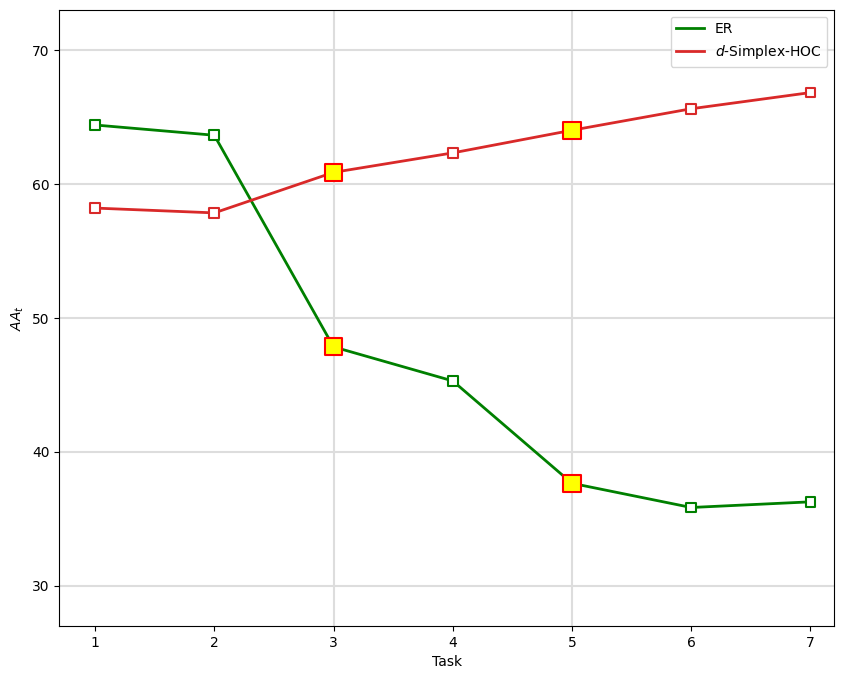

In [38]:
# plot AM per task
import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.usetex': False,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})
plt.rcParams["figure.figsize"] = (10,8)

er_values = average_accuracy(matrix=er_compatibility_matrix, per_task=True)
hoc_values = average_accuracy(matrix=hoc_compatibility_matrix, per_task=True)
ntasks = er_compatibility_matrix.shape[0]

fig, ax = plt.subplots()
replacemenet_ids = replace_ids[1:]
for idx in replacemenet_ids:
  plt.axvline(x=idx+1, color='#DDDDDD', linestyle='solid', lw=1.5, zorder=-5)
plt.grid(axis='y', color='#DDDDDD', linestyle='solid', lw=1.5, zorder=-5)
x = np.arange(1, ntasks+1)

face_colors = ['white' if not i in replacemenet_ids else 'yellow' for i in range(len(x))]
er_cols = ['green' if not i in replacemenet_ids else 'red' for i in range(len(x))]
hoc_cols = ['#D92929' if not i in replacemenet_ids else 'red' for i in range(len(x))]
sizes = [150 if i in replacemenet_ids else 50 for i in range(len(x))]

plt.plot(x, er_values, color='green', linestyle='solid', lw=2, zorder=2, label="ER")
plt.scatter(x, er_values, s=sizes, marker='s', edgecolors=er_cols, lw=1.5, facecolors=face_colors, zorder=2)

plt.plot(x, hoc_values, color='#D92929', linestyle='solid', lw=2, zorder=2, label=r"$d$-Simplex-HOC")
plt.scatter(x, hoc_values, s=sizes, marker='s', edgecolors=hoc_cols, lw=1.5, facecolors=face_colors, zorder=2)

plt.xticks(x)
plt.xlim(0.7, ntasks + 0.2)
ax.set_xlabel('Task')
ax.set_ylabel(r'${AA}_{t}$')
plt.legend()
plt.ylim(27, 73)
plt.show()